# Autoencoder study case: Denoising Autoencoder.

On this notebook we will cover the training of an autoencoder to reconstruct *notMNIST* dataset, and we will cover the next topics:
- notMNIST dataset
- Autoencoder Model architecture: 
    - Encoder and decoder
    - Upsampling2D
- Random Noise generation
- Reconstruct noisy data
### The dataset

Data can be obtained from [this repo](https://github.com/davidflanagan/notMNIST-to-MNIST). It consists on A-J characters, in a way similar to the MNIST data. Reading functions are provided in the next code lines:

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline


def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels
    
train_data = extract_data('/home/fer/data/formaciones/master/deep-learning-intro/datasets/notMNIST/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('/home/fer/data/formaciones/master/deep-learning-intro/datasets/notMNIST/t10k-images-idx3-ubyte.gz', 10000)

train_labels = extract_labels('/home/fer/data/formaciones/master/deep-learning-intro/datasets/notMNIST/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('/home/fer/data/formaciones/master/deep-learning-intro/datasets/notMNIST/t10k-labels-idx1-ubyte.gz',10000)

# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


Let's explore a bit the dataset. We will plot some of the examples:

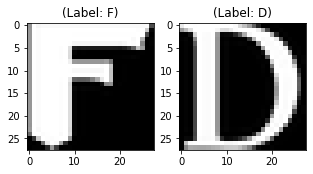

In [2]:
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

def plot_image(dataset, labels, sample_n):
    curr_img = np.reshape(dataset[sample_n], (28,28))
    curr_lbl = labels[sample_n]
    plt.imshow(curr_img, cmap='gray')
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
    

plt.figure(figsize=[5,5])
plt.subplot(121)
plot_image(train_data, train_labels, 0)

plt.subplot(122)
plot_image(test_data, test_labels, 0)

<font color=red><b>Plot some examples of the dataset.
<br>Hint: use the previously defined function function </b>
</font>

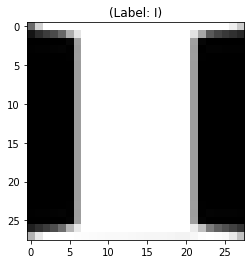

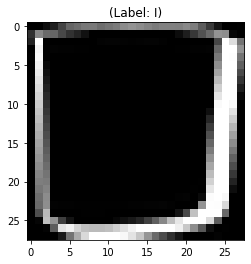

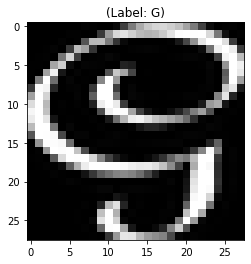

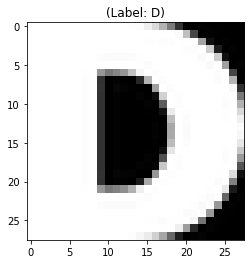

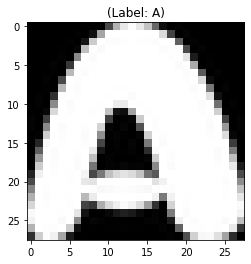

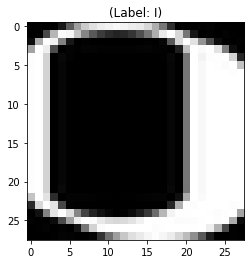

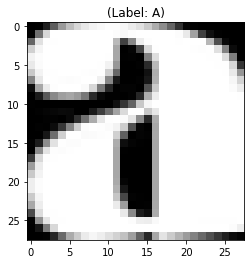

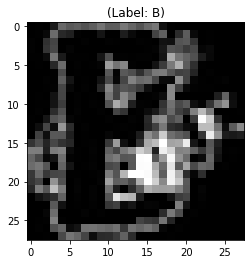

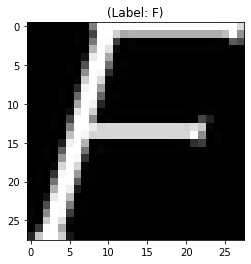

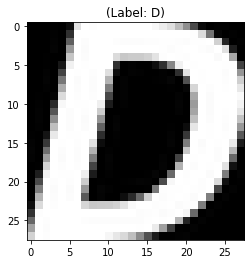

In [3]:
plt.figure(figsize=[4,4])
for j in range (10):
    plot_image(train_data, train_labels, j +1)
    plt.show()

### Data preparation
We will bound the dataset to [0,1] and reshape it to be (examples, width, height, channels)

In [4]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)

train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

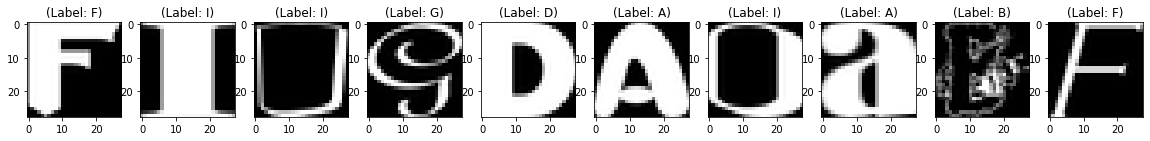

In [5]:
# A different view
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(train_data[i, ..., 0], cmap='gray')
    curr_lbl = train_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show() 

<font color=red><b>Generate a valid/train split on the training data. <b> WHY?</b>
<br>Hint: use the imported function function </b>
</font>

In [6]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

## Model Architecture:
We will build now an autoencoder. The purpose of it is to transform the image to a latent space and be able to reconstruct it, getting a compact representation of the data on the latent space. We will be using the functorial keras api for this, and will build both the encoder and the decoder at once:

- Encoder Architecture:
    - Use a Conv2D, with 32 filters 3x3, and relu activated. Use padding= 'same'
    - Add a maxpooling 2x2
    - Use a Conv2D, with 64 filters 3x3, and relu activated. Use padding= 'same'
    - Add a maxpooling 2x2
    - Use a Conv2D, with 128 filters 3x3, and relu activated. Use padding= 'same'
    - The result is now a small and thick representation.
- Decoder Architecture:
    - Use a Conv2D, with 128 filters 3x3, and relu activated. Use padding= 'same'
    - Add a upsampling2d 2x2
    - Use a Conv2D, with 64 filters 3x3, and relu activated. Use padding= 'same'
    - Add a upsampling2d 2x2
    - Use a Conv2D, with 1 filter 3x3, and relu activated. Use padding= 'same'


In [7]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.backend.clear_session()  # For easy reset of notebook state.
from tensorflow import keras

from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D



batch_size = 128
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
input_img

<tf.Tensor 'input_1:0' shape=(None, 28, 28, 1) dtype=float32>

<font color=red>Build the Autoencoder construction function. Please note we will be using *input_img* as the input
</font>

In [8]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

<font color=red>Build the autoencoder, using the implemented **Model** layer. compile it and train it. Store the training in the autoencoder_train function. Use the RMSprop optimizer and mean_squared_error as the loss
</font>

Please ignore the next cell. Its purpose is only to be used in case tensorflow/keras throws a session error.

In [9]:


from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

autoencoder.summary()

autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,
                                    validation_data=(valid_X, valid_ground))


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         147584

Let's plot the results of loss and validation loss. This is usefull for understanding how our models are performing

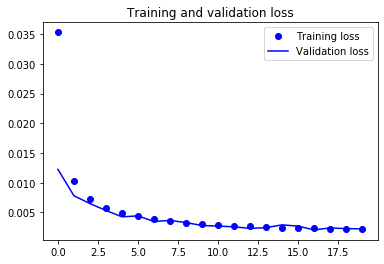

In [10]:
%matplotlib inline
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Let's see how it performs with the test data.
<font color=red> Print some examples of the test data and its reconstructions. <br> Hint: use some of the previously written lines of code
</font>

Test Images


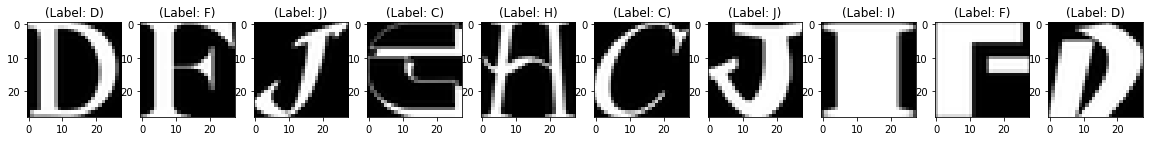

Reconstruction of Test Images


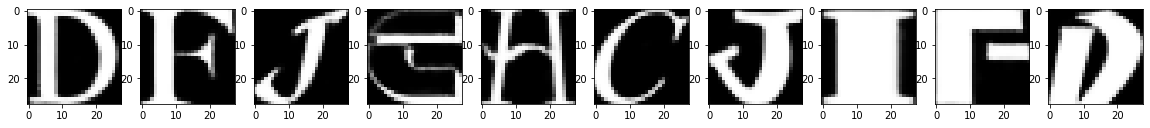

In [11]:
pred = autoencoder.predict(test_data)
%matplotlib inline
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()


## Denoising Autoencoder

Now let's make the autoencoder useful. So far we are evaluating reconstruction error from a *good* image to another one. Let's now introduce some noise into the data so that we will be improving the actual data.

<font color=red> Generate noisy data from the train/valid/test. <br> Hint: Use $$x\mapsto x + random\cdot 0.5$$
    
Where random comes from a normal distribution.
</font>

In [12]:
noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
# clip data for stability purposes
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

<font color=red> Plot some examples </font>

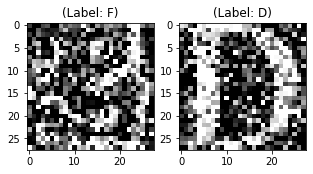

In [13]:
plt.figure(figsize=[5,5])
plt.subplot(121)
plot_image(x_train_noisy, train_labels, 0)

plt.subplot(122)
plot_image(x_test_noisy, test_labels, 0)

<font color=red> Build the denoising autoencoder and train it on the noisy data. Use the same architecture of the previous AE and the same optimizer/loss. <br> Hint: remember to build the model, compile it and store the training log </font>

In [14]:
# we will use the same values from the first ae. We need to rewrite the "epochs" variable
# batch_size = 128
epochs = 20
# inChannel = 1
# x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

def denoising_autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

denoising_autoencoder = Model(input_img, denoising_autoencoder(input_img))
denoising_autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
denoising_autoencoder_train = denoising_autoencoder.fit(x_train_noisy, train_X, batch_size=batch_size,
                                                        epochs=epochs,verbose=1,
                                                        validation_data=(x_valid_noisy, valid_X))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 10s 215us/sample - loss: 0.0509 - val_loss: 0.0276
Epoch 2/20
48000/48000 [==============================] - 9s 196us/sample - loss: 0.0239 - val_loss: 0.0203
Epoch 3/20
48000/48000 [==============================] - 10s 198us/sample - loss: 0.0205 - val_loss: 0.0193
Epoch 4/20
48000/48000 [==============================] - 10s 200us/sample - loss: 0.0188 - val_loss: 0.0178
Epoch 5/20
48000/48000 [==============================] - 9s 196us/sample - loss: 0.0178 - val_loss: 0.0170
Epoch 6/20
48000/48000 [==============================] - 10s 199us/sample - loss: 0.0170 - val_loss: 0.0174
Epoch 7/20
48000/48000 [==============================] - 9s 197us/sample - loss: 0.0164 - val_loss: 0.0164
Epoch 8/20
48000/48000 [==============================] - 10s 201us/sample - loss: 0.0160 - val_loss: 0.0164
Epoch 9/20
48000/48000 [==============================] - 9s 198us/sample - loss:

<font color=red>  Plot the validation and training loss </font>

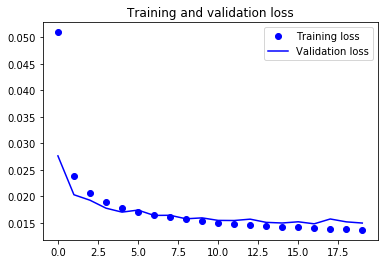

In [15]:
loss = denoising_autoencoder_train.history['loss']
val_loss = denoising_autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Let's see how it performs with the test data.
<font color=red> Print some examples of the test data and its reconstructions. <br> Hint: use some of the previously written lines of code
</font>

Test Images


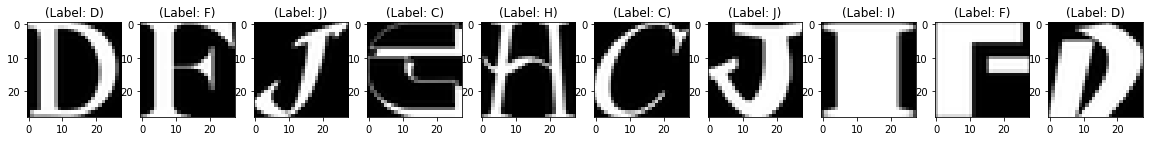

Test Images with Noise


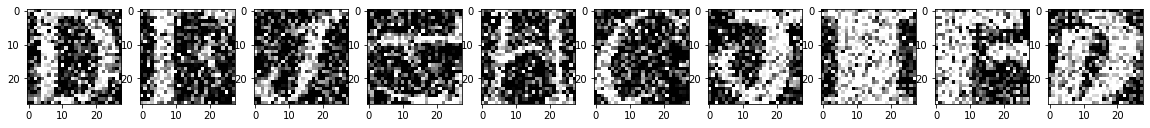

Reconstruction of Noisy Test Images


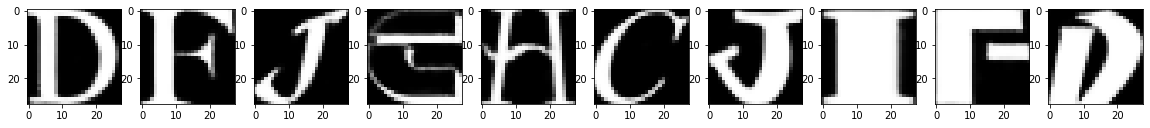

In [16]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()
